In [1]:
import sys
import os
from IPython.display import Markdown
from env_key_manager import APIKeyManager

APIKeyManager().setup_api_key([
    "DEEPSEEK_API_KEY", 
    "LANGSMITH_ENDPOINT", 
    "LANGSMITH_API_KEY", 
    "LANGSMITH_PROJECT"
])

os.environ['LANGSMITH_TRACING'] = "true"

# 查看Python版本
!python -V
# 查看安装的库
if 'win' in sys.platform.lower():
    !pip list | findstr "lang openai llm tiktoken chromadb cryptography duck unstructured numpy scipy"
else:
    !pip list | grep -E "lang|openai|llm|tiktoken|chromadb|cryptography|duck|unstructured|numpy|scipy"

Python 3.10.16
chromadb                                 0.6.3
cryptography                             44.0.2
duckduckgo_search                        6.3.7
langchain                                0.3.21
langchain-chroma                         0.2.2
langchain-community                      0.3.20
langchain-core                           0.3.49
langchain-deepseek                       0.1.3
langchain-openai                         0.3.11
langchain-text-splitters                 0.3.7
langgraph                                0.3.21
langgraph-checkpoint                     2.0.23
langgraph-prebuilt                       0.1.7
langgraph-sdk                            0.1.60
langserve                                0.3.1
langsmith                                0.3.8
numpy                                    1.26.4
openai                                   1.69.0
scipy                                    1.15.2
tiktoken                                 0.9.0


# 文本摘要

:::info

本教程演示了如何使用内置链和[LangGraph](https://langchain-ai.github.io/langgraph/)实现文本摘要。

[先前版本](https://python.langchain.com/v0.1/docs/use_cases/summarization/)的本页面展示了旧版链[StuffDocumentsChain](/docs/versions/migrating_chains/stuff_docs_chain/)、[MapReduceDocumentsChain](/docs/versions/migrating_chains/map_reduce_chain/)和[RefineDocumentsChain](https://python.langchain.com/docs/versions/migrating_chains/refine_docs_chain/)。有关使用这些抽象方法的信息及与本教程所示方法的对比，请参阅[此处](/docs/versions/migrating_chains/)。

:::

假设你有一组文档（PDF、Notion页面、客户问题等），并且你想要总结其中的内容。

鉴于大型语言模型在理解和综合文本方面的熟练程度，它们是实现这一目标的绝佳工具。

在[检索增强生成](/docs/tutorials/rag)的背景下，文本摘要有助于从大量检索到的文档中提炼信息，从而为大型语言模型（LLM）提供上下文。

在本教程中，我们将介绍如何使用大语言模型（LLMs）从多份文档中总结内容。

![图片描述](../../static/img/summarization_use_case_1.png)

## 概念

我们将涵盖的概念包括：

- 使用[语言模型](/docs/concepts/chat_models)。

- 使用[文档加载器](/docs/concepts/document_loaders)，特别是[WebBaseLoader](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)从HTML网页加载内容。

- 两种方法来总结或合并文档。
1. [填充](/docs/tutorials/summarization#stuff)，即简单地将文档串联成一个提示；
2. [Map-reduce（映射-归约）](/docs/tutorials/summarization#map-reduce)，适用于较大规模的文档集。该方法将文档分批处理，先对各批次进行摘要生成，再对生成的摘要进行二次汇总。

关于这些策略及其他方法的简短针对性指南（包括[迭代优化](/docs/how_to/summarize_refine)），可在[操作指南](/docs/how_to/#summarization)中找到。

## 安装设置

### Jupyter Notebook

本指南（以及文档中的大多数其他指南）使用 [Jupyter Notebooks](https://jupyter.org/)，并假设读者也在使用它。Jupyter Notebooks 非常适合学习如何使用 LLM 系统，因为经常会出现问题（意外的输出、API 宕机等），而在交互式环境中学习指南是更好地理解它们的绝佳方式。

本教程及其他教程或许在 Jupyter notebook 中运行最为便捷。有关安装说明，请参阅[此处](https://jupyter.org/install)。

### 安装

要安装LangChain，请运行：

import Tabs from '@theme/Tabs';
import TabItem from '@theme/TabItem';
import CodeBlock from "@theme/CodeBlock";

<Tabs>
  <TabItem value="pip" label="Pip" default>
<CodeBlock language="bash">pip install langchain</CodeBlock>
  </TabItem>
  <TabItem value="conda" label="Conda">
<CodeBlock language="bash">conda install langchain -c conda-forge</CodeBlock>
  </TabItem>
</Tabs>



更多详情，请参阅我们的[安装指南](/docs/how_to/installation)。

### LangSmith

使用LangChain构建的许多应用程序将包含多个步骤，涉及多次LLM调用。
随着这些应用变得越来越复杂，能够检查链或代理内部究竟发生了什么变得至关重要。
最佳方式是通过 [LangSmith](https://smith.langchain.com) 实现。

在以上链接完成注册后，请确保设置环境变量以开始记录追踪数据

## 概述

构建摘要生成器的核心问题在于如何将文档内容传递到大型语言模型(LLM)的上下文窗口中。对此通常有两种常见方法：

1. `Stuff`（堆叠法）：简单地将所有文档“堆叠”到一个提示中。这是最直接的方法（更多关于用于此方法的`create_stuff_documents_chain`构造函数的信息，请参见[此处](/docs/how_to/summarize_stuff/)）。

2. `Map-reduce`（映射-归约）：在“映射”步骤中独立总结每个文档，随后将各摘要“归约”为最终摘要（更多关于此方法使用的`MapReduceDocumentsChain`，请参见[此处](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.map_reduce.MapReduceDocumentsChain.html)）。

请注意，当对子文档的理解不依赖于前文时，Map-Reduce（映射-归约）方法尤其有效。例如，在总结由许多较短文档组成的语料库时。而在其他情况下，比如总结具有内在顺序的小说或文本主体时，[迭代优化](/docs/how_to/summarize_refine)方法可能更为有效。

![图片描述](../../static/img/summarization_use_case_2.png)

## 安装设置

首先设置环境变量并安装包：

In [ ]:
# %pip install --upgrade --quiet tiktoken langchain langgraph beautifulsoup4 langchain-community

# Set env var OPENAI_API_KEY or load from a .env file
# import dotenv

# dotenv.load_dotenv()

In [2]:
import os

os.environ["LANGSMITH_TRACING"] = "true"

首先我们加载文档。我们将使用 [WebBaseLoader](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html) 来加载一篇博客文章：

In [3]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [12]:
Markdown(docs[0].metadata['description'])

Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.
Long-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.


Tool use

The agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.




Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.

接下来让我们选择一个大型语言模型（LLM）：

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs
customVarName="llm"
/>

In [18]:
# | output: false
# | echo: false

from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(model="deepseek-chat", temperature=0)

## 资料：通过单次LLM调用进行总结 {#stuff}

我们可以使用 [create_stuff_documents_chain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html)，特别是在使用具有更大上下文窗口的模型时，例如：

* 128k token OpenAI `gpt-4o`
* 20万token Anthropic `claude-3-5-sonnet-20240620`

该链将接收一份文档列表，将它们全部插入到提示中，并将该提示传递给大型语言模型（LLM）：

In [20]:
from langchain.chains.combine_documents import create_stuff_documents_chain   # create_stuff_documents_chain: 从文档生成摘要
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# 定义提示
prompt = ChatPromptTemplate.from_messages(
    [("system", "为以下内容写一个简洁的摘要(zh):\\n\\n{context}")]
)

# 实例化链
chain = create_stuff_documents_chain(llm, prompt)

# 调用链
result = chain.invoke({"context": docs})
Markdown(result)

本文探讨了基于大型语言模型（LLM）的自主代理系统，介绍了其核心组件、案例研究和当前挑战。文章首先概述了代理系统的三个关键组成部分：规划（任务分解与自我反思）、记忆（短期与长期记忆）和工具使用（如API调用）。随后通过科学发现代理、生成式代理模拟等案例展示了实际应用场景，并分析了AutoGPT、GPT-Engineer等概念验证项目的实现机制。最后指出有限上下文长度、长期规划可靠性、自然语言接口稳定性等主要挑战，为LLM代理系统的未来发展提供了技术框架和思考方向。

### 流式传输

请注意，我们也可以逐令牌流式传输结果：

In [7]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

|The| article| "|LL|M| Powered| Autonomous| Agents|"| by| Lil|ian| W|eng| discusses| the| development| and| capabilities| of| autonomous| agents| powered| by| large| language| models| (|LL|Ms|).| It| outlines| a| system| architecture| that| includes| three| main| components|:| Planning|,| Memory|,| and| Tool| Use|.| 

|1|.| **|Planning|**| involves| task| decomposition|,| where| complex| tasks| are| broken| down| into| manageable| sub|go|als|,| and| self|-ref|lection|,| allowing| agents| to| learn| from| past| actions| to| improve| future| performance|.| Techniques| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| (|To|T|)| are| highlighted| for| enhancing| reasoning| and| planning|.

|2|.| **|Memory|**| is| categorized| into| short|-term| and| long|-term| memory|,| with| mechanisms| for| fast| retrieval| using| Maximum| Inner| Product| Search| (|M|IPS|)| algorithms|.| This| allows| agents| to| retain| and| recall| information| effectively|.

|3|.| **|Tool| Use|**| emphasiz

### 深入探索

* 你可以轻松自定义提示语。
* 您可以通过 `llm` 参数轻松尝试不同的大语言模型（例如 [Claude](/docs/integrations/chat/anthropic)）。

## Map-Reduce：通过并行化实现长文本摘要 {#map-reduce}

让我们来解析一下这种映射归约方法。具体步骤如下：首先，我们将使用大语言模型（LLM）为每份文档单独生成摘要（映射阶段）；随后，将这些独立摘要进行合并或整合，最终形成一个全局性的综合摘要（归约阶段）。

请注意，映射步骤通常会对输入文档进行并行处理。

[LangGraph](https://langchain-ai.github.io/langgraph/)构建于`langchain-core`之上，支持[map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)工作流，非常适合解决此类问题：

- LangGraph 支持流式传输各个步骤（例如连续摘要），从而实现对执行过程的更精细控制；
- LangGraph的[检查点功能](https://langchain-ai.github.io/langgraph/how-tos/persistence/)支持错误恢复、扩展为包含人工介入的工作流程，并能更轻松地集成到对话式应用中。
- 如下所示，LangGraph的实现易于修改和扩展。

### 地图
让我们首先定义与映射步骤相关的提示。我们可以使用与上述“填充”方法相同的摘要提示：

In [21]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "为以下内容写一个简洁的摘要：\\n\\n{context}")]
)

我们也可以使用提示中心来存储和获取提示。

这将与您的 [LangSmith API 密钥](https://docs.smith.langchain.com/) 配合使用。

例如，参见此处的映射提示[示例](https://smith.langchain.com/hub/rlm/map-prompt)。

```python
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")
```

### 减少

我们还定义了一个提示，该提示接收文档映射结果并将其缩减为单一输出。

In [22]:
# 也可以通过hub获取：`hub.pull("rlm/reduce-prompt")`
reduce_template = """
以下是一组摘要：
{docs}
请将这些摘要提炼成一个最终的、综合的主题摘要。
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

### 通过LangGraph进行编排

下面我们实现一个简单的应用程序，该程序首先对文档列表执行摘要生成步骤，然后使用上述提示对摘要进行归约处理。

当文本长度相对于大型语言模型（LLM）的上下文窗口较长时，Map-reduce（映射-归约）流程尤为实用。针对长文本，我们需要一种机制来确保在归约步骤中待汇总的上下文不超过模型的上下文窗口限制。此处我们实现了一种递归式"折叠"摘要方法：首先根据令牌限制对输入文本进行分区，并为每个分区生成摘要。若摘要总长度仍超出预期限制，则重复该步骤，直至满足要求，从而实现对任意长度文本的汇总。

首先我们将博客文章分割成较小的“子文档”以便进行映射：

In [23]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 14 documents.


接下来，我们定义我们的图。请注意，我们人为地将最大令牌长度设定为较低的1,000个令牌，以说明“折叠”步骤。

In [24]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """获取输入内容的令牌数量。"""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# 这将是主图的整体状态。
# 它将包含输入文档内容、相应的摘要和最终摘要。
class OverallState(TypedDict):
    # 注意这里我们使用operator.add
    # 这是因为我们希望将从各个节点生成的所有摘要
    # 合并回一个列表 - 这本质上是"归约"部分
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str

class SummaryState(TypedDict):
    """这将是我们用于"映射"所有文档以生成摘要的节点状态"""
    content: str


async def generate_summary(state: SummaryState):
    """这里我们根据文档生成摘要"""
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# 这里我们定义映射到文档的逻辑
# 我们将在图中使用这个作为边缘
def map_summaries(state: OverallState):
    # 我们将返回一个`Send`对象列表
    # 每个`Send`对象由图中节点的名称和要发送到该节点的状态组成
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    """这里我们将收集所有摘要"""
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    """这里我们将使用reduce-prompt来减少摘要"""
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# 添加节点以折叠摘要
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# 这表示图中的条件边缘，用于确定
# 我们是否应该折叠摘要
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# 这里我们将生成最终摘要
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# 构建图
# 节点:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # 与之前相同
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# 边缘:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

LangGraph 允许绘制图形结构，以帮助可视化其功能：

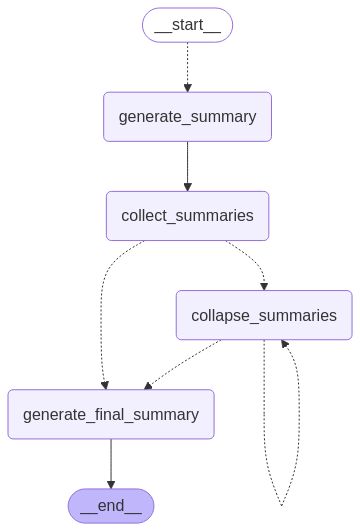

In [25]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

运行应用程序时，我们可以通过流式传输观察图的步骤序列。下面，我们将简单地打印出步骤的名称。

请注意，由于图中存在循环，在执行时指定 [recursion_limit](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError) 会很有帮助。当超过指定限制时，这将引发特定错误。

In [26]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']


GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [31]:
print(step)

{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the provided documents is as follows:\n\n1. **Integration of Large Language Models (LLMs) in Autonomous Agents**: The documents explore the evolving role of LLMs in autonomous systems, emphasizing their enhanced reasoning and acting capabilities through methodologies that incorporate structured planning, memory systems, and tool use.\n\n2. **Core Components of Autonomous Agents**:\n   - **Planning**: Techniques like task decomposition (e.g., Chain of Thought) and external classical planners are utilized to facilitate long-term planning by breaking down complex tasks.\n   - **Memory**: The memory system is divided into short-term (in-context learning) and long-term memory, with parallels drawn between human memory and machine learning to improve agent performance.\n   - **Tool Use**: Agents utilize external APIs and algorithms to enhance problem-solving abilities, exemplified by frameworks lik

在对应的 [LangSmith 追踪记录](https://smith.langchain.com/public/9d7b1d50-e1d6-44c9-9ab2-eabef621c883/r) 中，我们可以看到各个独立的LLM调用，它们按照各自的节点分组显示。

### 深入探索
 
**自定义**

* 如上所示，您可以针对映射（map）和归约（reduce）阶段自定义大语言模型（LLMs）及提示词。

**实际应用场景**

* 查看[这篇博客文章](https://blog.langchain.dev/llms-to-improve-documentation/)中关于分析用户交互（针对LangChain文档的提问）的案例研究！
* 这篇博客文章及相关的[代码库](https://github.com/mendableai/QA_clustering)还介绍了将聚类作为摘要生成的一种方法。
* 这开辟了除`stuff`或`map-reduce`方法之外的另一条值得考虑的路径。

![图片描述](../../static/img/summarization_use_case_3.png)

## 后续步骤

我们鼓励您查阅[操作指南](/docs/how_to)以获取以下方面的更多详细信息：

- 其他摘要策略，例如[迭代优化](/docs/how_to/summarize_refine)
- 内置的[文档加载器](/docs/how_to/#document-loaders)和[文本分割器](/docs/how_to/#text-splitters)
- 将各种组合文档链集成到 [RAG 应用](/docs/tutorials/rag/) 中
- 将检索功能整合到[聊天机器人](/docs/how_to/chatbots_retrieval/)中

以及其他概念。